In [1]:
from typing import List
import pandas
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import os

image_size = 120

train_path = "train/"
test_path = "test/"

testLabels = os.listdir(test_path)
trainLabels = os.listdir(train_path)


data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(height_factor=0.2, width_factor=0.2),
    ],
    name="data_augmentation",
)

def dataLoader(aboPath:str, paths:List[str], plus:int = 2):
    inputs = []
    targets = []
    for index, i in enumerate(paths):
        sub = os.path.join(aboPath, i)
        imgdir = os.listdir(sub)
        # for i in imgdir:
        for i in imgdir:
            if not "Copy" in i:
                    
                image = keras.utils.load_img(
                    os.path.join(sub, i),
                )
                image = image.resize((image_size, image_size))
                inputs.append(keras.utils.img_to_array(image))
                targets.append(index)
                for l in range(plus):
                    inputs.append(data_augmentation(keras.utils.img_to_array(image)))
                    targets.append(index)
    return (np.asarray(inputs)/255., np.asarray(targets)) 

val_data = dataLoader(test_path, testLabels)
train_data = dataLoader(train_path, trainLabels)



2023-12-20 10:25:47.663626: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-20 10:25:47.686481: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-20 10:25:47.686511: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-20 10:25:47.686524: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-20 10:25:47.690976: I tensorflow/core/platform/cpu_feature_g

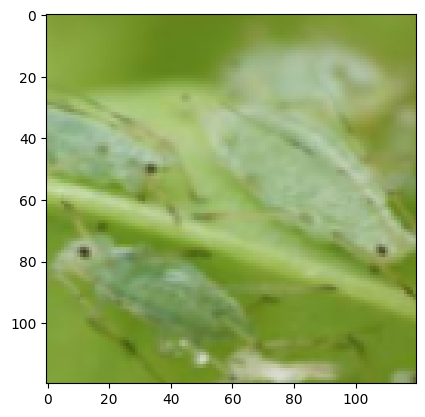

In [73]:
img = data_augmentation(train_data[0][0])
plt.imshow(img)

In [2]:
modelName = "VGG16" 
vgg16 = keras.applications.VGG16(
    include_top=False,
    weights="imagenet",
    input_shape=(image_size, image_size, 3),
)
for layer in vgg16.layers:     
    layer.trainable = True
    

x = layers.AveragePooling2D()(vgg16.output)
# x = layers.MaxPooling2D(x)
output = layers.Flatten()(x)
output = layers.Dense(1024, tf.nn.relu)(output)
output = layers.Dense(len(np.unique(train_data[1])), activation="softmax")(output)
model = keras.Model(inputs = vgg16.input, outputs = output)

In [2]:
modelName = "VGG19" 
vgg16 = keras.applications.VGG19(
    include_top=False,
    weights="imagenet",
    input_shape=(image_size, image_size, 3),
)
for layer in vgg16.layers:     
    layer.trainable = True
    

x = layers.AveragePooling2D()(vgg16.output)
# x = layers.MaxPooling2D(x)
output = layers.Flatten()(x)
output = layers.Dense(1024, tf.nn.relu)(output)
output = layers.Dense(len(np.unique(train_data[1])), activation="softmax")(output)
model = keras.Model(inputs = vgg16.input, outputs = output)

In [2]:
modelName = "Xception" 
Xception = keras.applications.Xception(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))
for layer in Xception.layers:     
    layer.trainable = True

x = layers.AveragePooling2D()(Xception.output)
# x = layers.MaxPooling2D(x)
output = layers.Flatten()(x)
output = layers.Dense(1024, tf.nn.relu)(output)
output = layers.Dense(len(np.unique(train_data[1])), activation="softmax")(output)
model = keras.Model(inputs = Xception.input, outputs = output)

In [2]:
modelName = "EfficientNetB0" 
Xception = keras.applications.EfficientNetB0(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))
for layer in Xception.layers:     
    layer.trainable = True

x = layers.Conv2D(32, 3)(Xception.input)
# x = layers.MaxPooling2D(x)
output = layers.Flatten()(x)
output = layers.Dense(1024, tf.nn.relu)(output)
output = layers.Dense(len(np.unique(train_data[1])), activation="softmax")(output)
model = keras.Model(inputs = Xception.input, outputs = output)

16705208/16705208 [==============================] - 2s 0us/step


Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 120, 120, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, 120, 120, 3)       7         
 ial)                                                            
                                                                 
 conv2d_10 (CONV2D)          (None, 60, 60, 64)        2048      
                                                                 
 conv2d_12 (CONV2D)          (None, 30, 30, 128)       74368     
                                                                 
 conv2d_14 (CONV2D)          (None, 15, 15, 256)       296192    
                                                                 
 flatten_4 (Flatten)         (None, 57600)             0         
                                                           

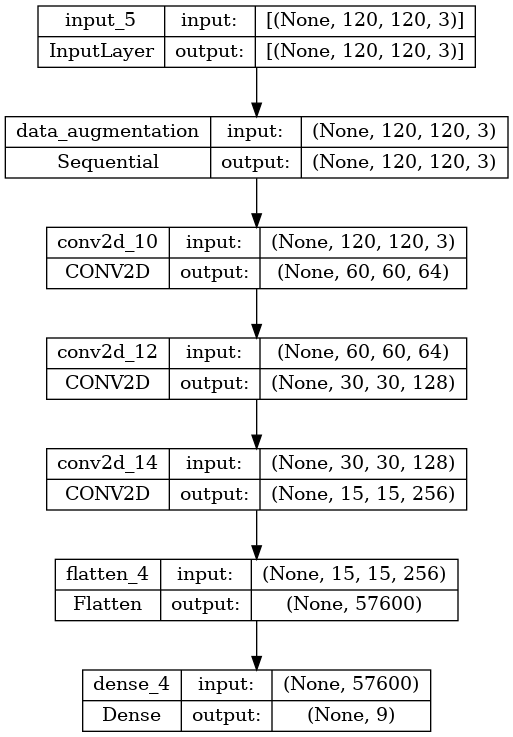

In [18]:

Input = keras.Input((image_size, image_size, 3))
x = data_augmentation(Input)

class CONV2D(layers.Layer):
    def __init__(self, kenel):
        super().__init__()
        self.x1 = layers.Conv2D(kenel, 3, activation = "relu", padding="same")
        self.x2 = layers.BatchNormalization()
        self.x3 = layers.MaxPooling2D()
        self.x4 = layers.Dropout(0.4)
    def call(self, x):
        x = self.x1(x)        
        x = self.x2(x)        
        x = self.x3(x)        
        x = self.x4(x) 
        return x       

x = CONV2D(64)(x)
x = CONV2D(128)(x)
x = CONV2D(256)(x)

x = layers.Flatten()(x)
x = layers.Dense(len(np.unique(val_data[1])), tf.nn.softmax)(x)

model = keras.Model(inputs = Input, outputs = x)
model.summary()

tf.keras.utils.plot_model(model, show_shapes=True)


In [3]:

# es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20) 
# rLR = tf.keras.callbacks.ReduceLROnPlateau (
#     monitor='val_loss',
#     factor=0.6,
#     patience=3,
#     min_lr=1e-12,
#     verbose=1,
# )

model.compile("Adam", loss = tf.losses.SparseCategoricalCrossentropy(), metrics=["accuracy"])


In [4]:

history = model.fit(train_data[0], train_data[1], batch_size= 10, epochs=200, validation_data=val_data)
# history = model.fit(train_data[0], train_data[1], batch_size= 10, epochs=200, validation_data=val_data, callbacks=[es, rLR])


Epoch 1/200


2023-12-20 10:30:29.606988: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8904
2023-12-20 10:30:30.670818: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7faf04020f40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-20 10:30:30.670924: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4070, Compute Capability 8.9
2023-12-20 10:30:30.674302: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-12-20 10:30:30.734708: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


119/119 [==============================] - 10s 34ms/step - loss: 2.3100 - accuracy: 0.1301 - val_loss: 2.2492 - val_accuracy: 0.1253
Epoch 2/200
119/119 [==============================] - 3s 27ms/step - loss: 2.2009 - accuracy: 0.1478 - val_loss: 2.1987 - val_accuracy: 0.1078
Epoch 3/200
119/119 [==============================] - 3s 27ms/step - loss: 2.1902 - accuracy: 0.1503 - val_loss: 2.2028 - val_accuracy: 0.1078
Epoch 4/200
119/119 [==============================] - 3s 27ms/step - loss: 2.1885 - accuracy: 0.1503 - val_loss: 2.2027 - val_accuracy: 0.1078
Epoch 5/200
119/119 [==============================] - 3s 27ms/step - loss: 2.1888 - accuracy: 0.1503 - val_loss: 2.2048 - val_accuracy: 0.1078
Epoch 6/200
119/119 [==============================] - 3s 26ms/step - loss: 2.1881 - accuracy: 0.1503 - val_loss: 2.2028 - val_accuracy: 0.1078
Epoch 7/200
119/119 [==============================] - 3s 26ms/step - loss: 2.1882 - accuracy: 0.1503 - val_loss: 2.2013 - val_accuracy: 0.1078
Epo

In [5]:
model.save(f'{modelName}.keras')

In [6]:
valLoss = history.history["val_loss"]
valAccuracy = history.history["val_accuracy"]
Loss = history.history["loss"]
Accuracy = history.history["accuracy"]

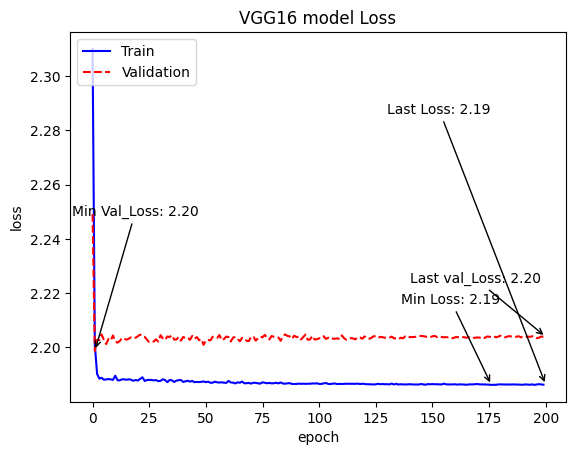

In [16]:
plt.title(f'{modelName} model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.plot(Loss, "b")
plt.plot(valLoss, "r--")
plt.legend(['Train', 'Validation'], loc='upper left')

max_acc = min(Loss)
max_acc_epoch = np.argmin(Loss)

plt.annotate(f"Min Loss: {max_acc:.2f}", xy=(max_acc_epoch, max_acc), xytext=(max_acc_epoch-40 , max_acc + 0.03),
arrowprops=dict(facecolor='blue', arrowstyle='->'))

plt.annotate(f"Last Loss: {Loss[-1]:.2f}", xy=(len(Loss), Loss[-1]), xytext=(len(Loss)-70, Loss[-1] + 0.1),
arrowprops=dict(facecolor='blue', arrowstyle='->'))

max_valacc = min(valLoss)
max_valacc_epoch = np.argmin(valLoss)

plt.annotate(f"Min Val_Loss: {max_valacc:.2f}", xy=(max_valacc_epoch, max_valacc), xytext=(max_valacc_epoch-10, max_valacc + 0.05),
arrowprops=dict(facecolor='blue', arrowstyle='->'))

plt.annotate(f"Last val_Loss: {valLoss[-1]:.2f}", xy=(len(valLoss), valLoss[-1]), xytext=(len(valLoss)-60, valLoss[-1] + 0.02),
arrowprops=dict(facecolor='blue', arrowstyle='->'))

plt.legend(['Train', 'Validation'], loc='upper left')

plt.savefig(f"{modelName}_Loss.png")

0.9915540814399719
0.9348371028900146


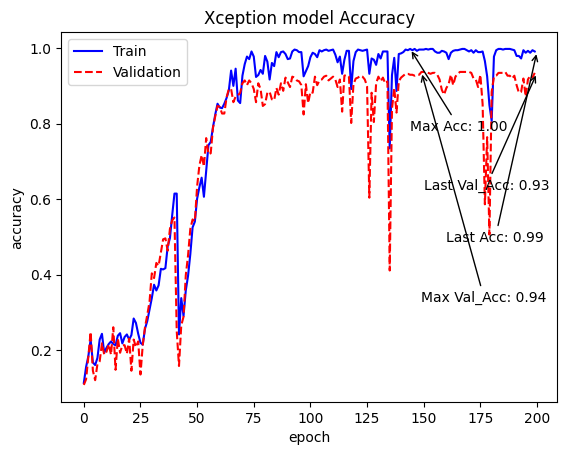

In [29]:
plt.title(f'{modelName} model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.plot(Accuracy, "b")
plt.plot(valAccuracy, "r--")
             
max_acc = max(Accuracy)
max_acc_epoch = np.argmax(Accuracy)

plt.annotate(f"Max Acc: {max_acc:.2f}", xy=(max_acc_epoch, max_acc), xytext=(max_acc_epoch, max_acc - 0.217),
arrowprops=dict(facecolor='blue', arrowstyle='->'))

plt.annotate(f"Last Acc: {Accuracy[-1]:.2f}", xy=(len(Accuracy), Accuracy[-1]), xytext=(len(Accuracy)-40, Accuracy[-1]- 0.505),
arrowprops=dict(facecolor='blue', arrowstyle='->'))

max_valacc = max(valAccuracy)
max_valacc_epoch = np.argmax(valAccuracy)
print(Accuracy[-1])
print(valAccuracy[-1])
plt.annotate(f"Max Val_Acc: {max_valacc:.2f}", xy=(max_valacc_epoch, max_valacc), xytext=(max_valacc_epoch, max_valacc - 0.61),
arrowprops=dict(facecolor='blue', arrowstyle='->'))

plt.annotate(f"Last Val_Acc: {valAccuracy[-1]:.2f}", xy=(len(valAccuracy), valAccuracy[-1]), xytext=(len(valAccuracy)-50, valAccuracy[-1]-0.31),
arrowprops=dict(facecolor='blue', arrowstyle='->'))

plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig(f"{modelName}_Acc.png")

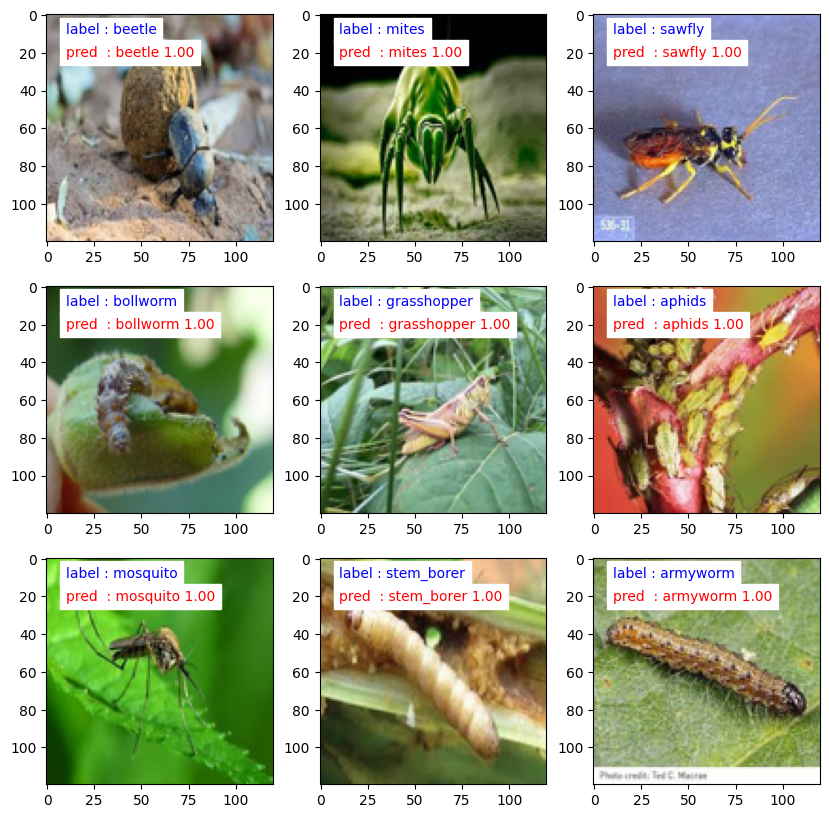

In [32]:
i, t = val_data
fig,axs = plt.subplots(3,3,figsize=(10,10))
c = []
index = np.random.randint(0, len(t))
for row in range(0, 3):
    for column in range(0, 3):
        while (t[index] in c):
            index = np.random.randint(0, len(t))
        c.append(t[index])

        # print(index)
        img = np.expand_dims(i[index], 0)
        pred = model.predict(img, verbose=0)

        axs[column][row].imshow(i[index])
        # axs[column][row].axis('off')
        # axs[column][row].title.set_text(testLabels[t[index]]+" <-|-> "+testLabels[np.argmax(model.predict(img))])
        axs[column][row].text(10, 10, "label : "+testLabels[t[index]], color='blue', backgroundcolor='white')
        axs[column][row].text(10, 22, "pred  : "+testLabels[np.argmax(pred)] + f" {np.max(pred):0.2f}", color='red', backgroundcolor='white')
plt.savefig(f"{modelName}_pred.png")
